Objective: Determine Weyl chamber regions spanned by x iterations of $\sqrt[n]{iSwap}$ circuit templates.\
a. Step through weyl coordinates -> Pass to NuOp -> Color point based on length of template required\
b. (Later) Vectorization ML Task

In [1]:
import numpy as np
import weylchamber
from nuop_script import TemplateCircuit
from scipy import optimize as opt
import pickle
import weylchamber

In [2]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
class TemplateOptimizer:
    def __init__(
        self,
        template,
        weyl_coordinates=(0,0,0),
        objective_function_name="square",
        template_iter_range=range(2, 4)
    ):
        """Args:
        template: TemplateCircuit object
        objective_function_name: "nuop|basic" or "weyl"
        unitary_sample_function: "Haar" or "Clifford for random sampling, "SWAP", "CNOT", "iSWAP" for single gates
        n_samples: the number of times to sample a gate and minimize template on
        template_iter_range: a range() object that whos values are passed to template.build()
        """
        self.template = template
        self.weyl_coordinates = weyl_coordinates
        self.obj_f_name = objective_function_name
        self.template_iter_range = template_iter_range

    def run(self):
        # run minimize on the remaining samples
        best_result, best_Xk, best_cycles = None, None, None

        obj = self._objective_function(self.obj_f_name)
        best_result, best_Xk, best_cycles = self.minimize(
            obj=obj, t_range=self.template_iter_range)
                
        return best_result, best_Xk, best_cycles

    def minimize(self, obj, t_range):
        # NOTE: potential for speedup?
        # you can calculate ahead of time the number of repetitions needed using traces??

        # callback used to save current loss after each iteration
        # def callbackF(xk):
        #     loss = obj(xk)
        #     temp_training_loss.append(loss)

        best_result = None
        best_Xk = None
        best_cycles = -1

        # each t creates fresh template with new repetition param
        for t in t_range:
            logging.info(f"Starting cycle length {t}")

            self.template.build(n_repetitions=t)

            starting_attempts = 5
            for _ in range(starting_attempts):
                result = opt.minimize(
                    fun=obj,
                    x0=self.template.initial_guess(),
                    options={"maxiter": 200},
                )

                # result is good, update temp vars
                if best_result is None or result.fun < best_result:
                    best_result = result.fun
                    best_Xk = result.x
                    best_cycles = self.template.cycles

                # already good enough, save time by stopping here
                if best_result < 1e-9:
                    logging.info(f"Break on cycle {t}")
                    break

            if best_result < 1e-9:
                break

        logging.info(f"loss= {best_result}")
        return best_result, best_Xk, best_cycles

    def _objective_function(self, name):
        if name == "square":
            target = weylchamber.canonical_gate(*self.weyl_coordinates).full()
            return lambda X: 1 - (
                np.abs(np.trace(np.matmul(np.matrix(target).getH(), self.template.eval(X)))) ** 2
                + np.array(target).shape[0]
            ) / (np.array(target).shape[0] * (np.array(target).shape[0] + 1))
        else:
            raise ValueError(f"No objective function named {name}")

In [4]:
def _pickle_load(filename):
    #try to open file if it exists
    try:
        with open(filename, 'rb') as f:
            loaded_data = pickle.load(f)
    except FileNotFoundError:
        loaded_data = {}
    #    with open(filename, 'a') as f:
    #        #do nothing, just want to create file
    #        pass
    return loaded_data

In [5]:
def collect_data(N=1, riswap_param=1/2, template_range=[2], filename=None, overwrite_saved=False):
    """This method generates a Weyl Chamber point, converts it to a gate, then asks NuOp how many template cycles it needs to make that gate"""

    circuit = TemplateCircuit(gate_2q_params=[riswap_param])
    dict_data = {} #(coordinate : (result, Xk, cycles))

    if filename is None:
        filename = f"data/weyl_spanning_1-{str(int(1/riswap_param))}.pkl"
    dict_data = _pickle_load(filename) if not overwrite_saved else {}

    #we don't want this to be random, this is used for filling in the weyl chamber regions missed in other data collection method
    #weyl_coordinate_list = [weylchamber.random_weyl_point() for _ in range(N-len(dict_data.keys()))]
    #define edge O->P->A3
    point_O = (0,0,0)
    point_A1 = (1, 0, 0)
    point_A2 = (1/2, 1/2,0)
    point_A3 = (1/2,1/2,1/2)
    exterior_edges = [(point_O, point_A1), (point_O, point_A2), (point_O, point_A3), (point_A1, point_A2), (point_A1, point_A2), (point_A2, point_A3)]
    
    weyl_coordinate_list = []
    for edge_A, edge_B in exterior_edges:
        temp_coord = [(x,y,z) for x,y,z in zip(*[np.linspace(edge_A[i], edge_B[i], num=N) for i in range(len(point_O))])]
        weyl_coordinate_list.extend(temp_coord)
        
    for coord_index, coordinate in enumerate(weyl_coordinate_list):
        #check if coordinate already exists in loaded_data
        if coordinate in dict_data.keys():
            logging.info(f"({1+coord_index}/{len(weyl_coordinate_list)}) Found saved coordinate: {coordinate}")
            continue

        logging.info(f"({1+coord_index}/{len(weyl_coordinate_list)}) Training coordinate: {coordinate}")
        optimizer = TemplateOptimizer(circuit, weyl_coordinates=coordinate, objective_function_name="square", template_iter_range=template_range)
        best_result, best_Xk, best_cycles = optimizer.run()

        if best_result > 1e-9:
            #raise ValueError("Failed to converge, try adjusting max_template_size")
            #rather than raise failed to converge error, just save its actual reached coordinate
            dict_data[coordinate] = None #mark old coordinate as unreachable
            coordinate = weylchamber.c1c2c3(circuit.eval(best_Xk))
            logging.info(f"Given coordinate failed, instead found closest point was {coordinate}")
            best_result = 0 #by definition, since we are declaring coordinate equal to the state of the template circuit

        #write into temp data dict
        dict_data[coordinate] = (best_result, best_Xk, best_cycles)

    
    #at end, save back data dict
    logging.info("Saving data back to file")
    with open(filename, 'wb+') as f:
        pickle.dump(dict_data, f)

    return dict_data

def collect_data2(N=100, riswap_param=1/2, template_range=[2,3]):
    """In contrast, this generates a template of a set size, then randomly sets parameters to see where it ends up in the Weyl Chamber"""
    temp_data = {}
    for template_size in template_range:
        circuit = TemplateCircuit(gate_2q_params=[riswap_param])
        circuit.build(template_size)

        for _ in range(N):
            Xk = circuit.initial_guess()
            random_U = circuit.eval(Xk)
            coordinate = weylchamber.c1c2c3(random_U)
            temp_data[coordinate] = template_size
    return temp_data

In [6]:
%matplotlib widget
#this command lets the weyl chamber be rotated in 3d

In [7]:
c = ["black", "black", "tab:blue", "tab:orange", "tab:green", "tab:red"]

def weyl_region_plot(riswap_param=1/2, template_range=[2]):
    w= weylchamber.WeylChamber()

    #Step 1. Add the Template -> Weyl chamber points
    #We expect these to be clustered in the center
    # loaded_data = collect_data2(N=100, riswap_param=riswap_param, template_range=[2])
    # for coordinate, result in loaded_data.items():
    #     color = c[result%len(c)]
    #     w.scatter(*coordinate, color=color)

    #Step 2. Add the Weyl Chamber points -> Template length data
    #This is useful for forcing coordinates that aren't reached by the random distribution

    N=10
    #set template_size=2, so if it fails, we instead get back its closest guess in order to create internal weyl edges
    filename = f"data/weyl_spanning_1-{str(int(1/riswap_param))}-{template_range}.pkl"
    loaded_data = collect_data(N=N, riswap_param=riswap_param, template_range=template_range, filename=filename)
    # loaded_data = _pickle_load(filename)

    for coordinate, result in loaded_data.items():
        # check that optimizer successfully converged
        if result is not None and result[0] < 1e-9:

            # color that coordinate with best_cycles->color
            color = c[result[2]%len(c)]
            w.scatter(*coordinate, color=color)

    return w

INFO:root:(1/60) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/60) Found saved coordinate: (0.1111111111111111, 0.0, 0.0)
INFO:root:(3/60) Found saved coordinate: (0.2222222222222222, 0.0, 0.0)
INFO:root:(4/60) Found saved coordinate: (0.3333333333333333, 0.0, 0.0)
INFO:root:(5/60) Found saved coordinate: (0.4444444444444444, 0.0, 0.0)
INFO:root:(6/60) Found saved coordinate: (0.5555555555555556, 0.0, 0.0)
INFO:root:(7/60) Found saved coordinate: (0.6666666666666666, 0.0, 0.0)
INFO:root:(8/60) Found saved coordinate: (0.7777777777777777, 0.0, 0.0)
INFO:root:(9/60) Found saved coordinate: (0.8888888888888888, 0.0, 0.0)
INFO:root:(10/60) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(11/60) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(12/60) Found saved coordinate: (0.05555555555555555, 0.05555555555555555, 0.0)
INFO:root:(13/60) Found saved coordinate: (0.1111111111111111, 0.1111111111111111, 0.0)
INFO:root:(14/60) Found saved coordinate: (0.16666666666666666, 0.1666666

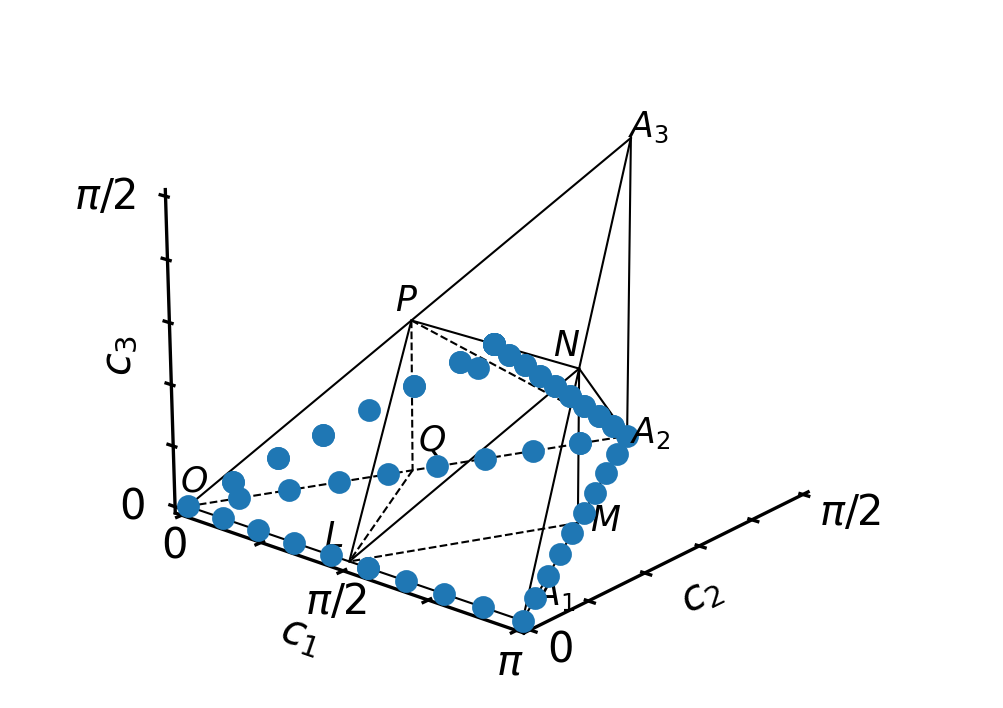

In [8]:
weyl_region_plot(riswap_param=1/2, template_range=[2]).plot()

INFO:root:(1/60) Training coordinate: (0.0, 0.0, 0.0)
INFO:root:Starting cycle length 3
INFO:root:Break on cycle 3
INFO:root:loss= 1.750543043854691e-10
INFO:root:(2/60) Training coordinate: (0.1111111111111111, 0.0, 0.0)
INFO:root:Starting cycle length 3
INFO:root:Break on cycle 3
INFO:root:loss= 8.960017172654489e-10
INFO:root:(3/60) Training coordinate: (0.2222222222222222, 0.0, 0.0)
INFO:root:Starting cycle length 3
INFO:root:Break on cycle 3
INFO:root:loss= 5.395154323295515e-10
INFO:root:(4/60) Training coordinate: (0.3333333333333333, 0.0, 0.0)
INFO:root:Starting cycle length 3
INFO:root:Break on cycle 3
INFO:root:loss= 1.1386036558036494e-10
INFO:root:(5/60) Training coordinate: (0.4444444444444444, 0.0, 0.0)
INFO:root:Starting cycle length 3
INFO:root:Break on cycle 3
INFO:root:loss= 2.0948454082514445e-10
INFO:root:(6/60) Training coordinate: (0.5555555555555556, 0.0, 0.0)
INFO:root:Starting cycle length 3
INFO:root:Break on cycle 3
INFO:root:loss= 8.591083400233401e-11
INFO:

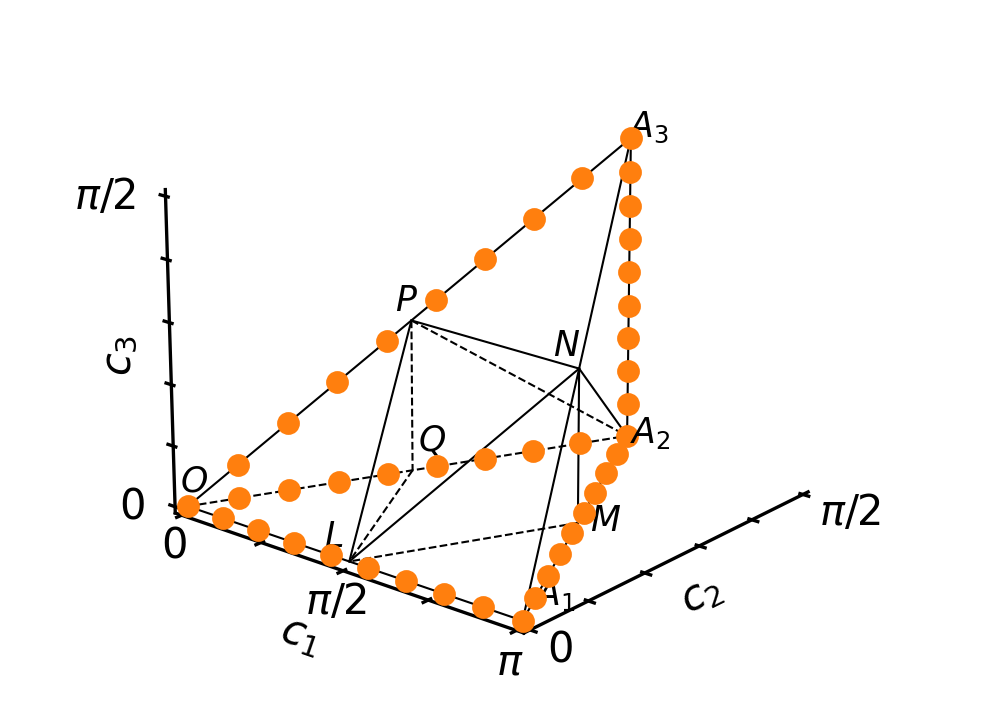

In [9]:
weyl_region_plot(riswap_param=1/2, template_range=[3]).plot()

INFO:root:(1/60) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/60) Found saved coordinate: (0.1111111111111111, 0.0, 0.0)
INFO:root:(3/60) Found saved coordinate: (0.2222222222222222, 0.0, 0.0)
INFO:root:(4/60) Found saved coordinate: (0.3333333333333333, 0.0, 0.0)
INFO:root:(5/60) Found saved coordinate: (0.4444444444444444, 0.0, 0.0)
INFO:root:(6/60) Found saved coordinate: (0.5555555555555556, 0.0, 0.0)
INFO:root:(7/60) Found saved coordinate: (0.6666666666666666, 0.0, 0.0)
INFO:root:(8/60) Found saved coordinate: (0.7777777777777777, 0.0, 0.0)
INFO:root:(9/60) Found saved coordinate: (0.8888888888888888, 0.0, 0.0)
INFO:root:(10/60) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(11/60) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(12/60) Found saved coordinate: (0.05555555555555555, 0.05555555555555555, 0.0)
INFO:root:(13/60) Found saved coordinate: (0.1111111111111111, 0.1111111111111111, 0.0)
INFO:root:(14/60) Found saved coordinate: (0.16666666666666666, 0.1666666

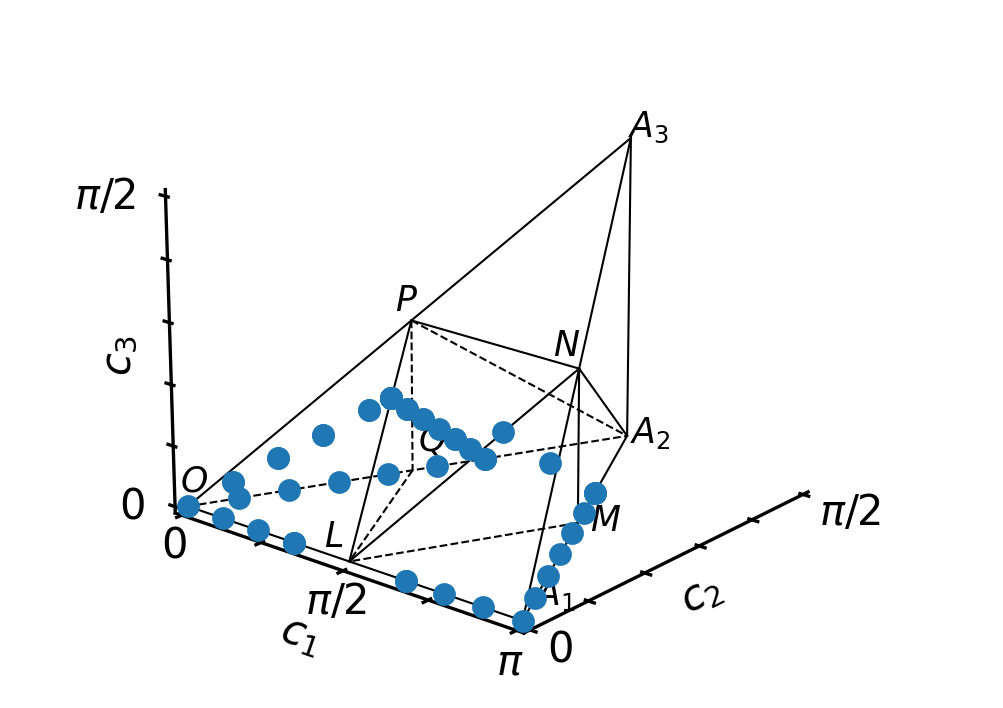

In [10]:
weyl_region_plot(riswap_param=1/3, template_range=[2]).plot()

INFO:root:(1/60) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/60) Found saved coordinate: (0.1111111111111111, 0.0, 0.0)
INFO:root:(3/60) Found saved coordinate: (0.2222222222222222, 0.0, 0.0)
INFO:root:(4/60) Found saved coordinate: (0.3333333333333333, 0.0, 0.0)
INFO:root:(5/60) Found saved coordinate: (0.4444444444444444, 0.0, 0.0)
INFO:root:(6/60) Found saved coordinate: (0.5555555555555556, 0.0, 0.0)
INFO:root:(7/60) Found saved coordinate: (0.6666666666666666, 0.0, 0.0)
INFO:root:(8/60) Found saved coordinate: (0.7777777777777777, 0.0, 0.0)
INFO:root:(9/60) Found saved coordinate: (0.8888888888888888, 0.0, 0.0)
INFO:root:(10/60) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(11/60) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(12/60) Found saved coordinate: (0.05555555555555555, 0.05555555555555555, 0.0)
INFO:root:(13/60) Found saved coordinate: (0.1111111111111111, 0.1111111111111111, 0.0)
INFO:root:(14/60) Found saved coordinate: (0.16666666666666666, 0.1666666

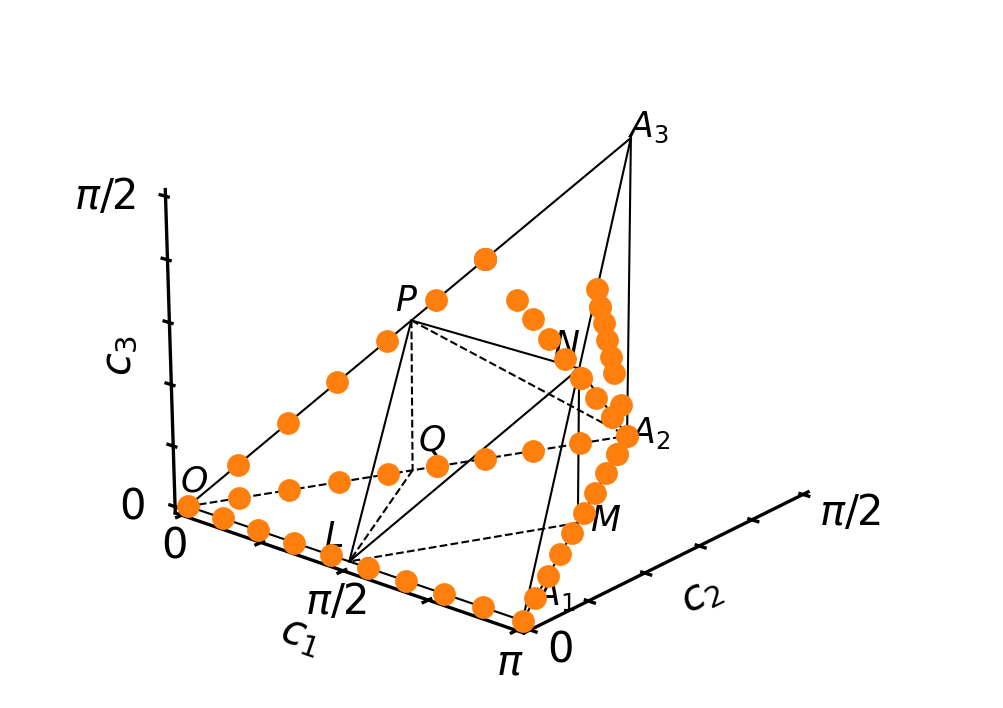

In [11]:
weyl_region_plot(riswap_param=1/3, template_range=[3]).plot()

INFO:root:(1/60) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/60) Found saved coordinate: (0.1111111111111111, 0.0, 0.0)
INFO:root:(3/60) Found saved coordinate: (0.2222222222222222, 0.0, 0.0)
INFO:root:(4/60) Found saved coordinate: (0.3333333333333333, 0.0, 0.0)
INFO:root:(5/60) Found saved coordinate: (0.4444444444444444, 0.0, 0.0)
INFO:root:(6/60) Found saved coordinate: (0.5555555555555556, 0.0, 0.0)
INFO:root:(7/60) Found saved coordinate: (0.6666666666666666, 0.0, 0.0)
INFO:root:(8/60) Found saved coordinate: (0.7777777777777777, 0.0, 0.0)
INFO:root:(9/60) Found saved coordinate: (0.8888888888888888, 0.0, 0.0)
INFO:root:(10/60) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(11/60) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(12/60) Found saved coordinate: (0.05555555555555555, 0.05555555555555555, 0.0)
INFO:root:(13/60) Found saved coordinate: (0.1111111111111111, 0.1111111111111111, 0.0)
INFO:root:(14/60) Found saved coordinate: (0.16666666666666666, 0.1666666

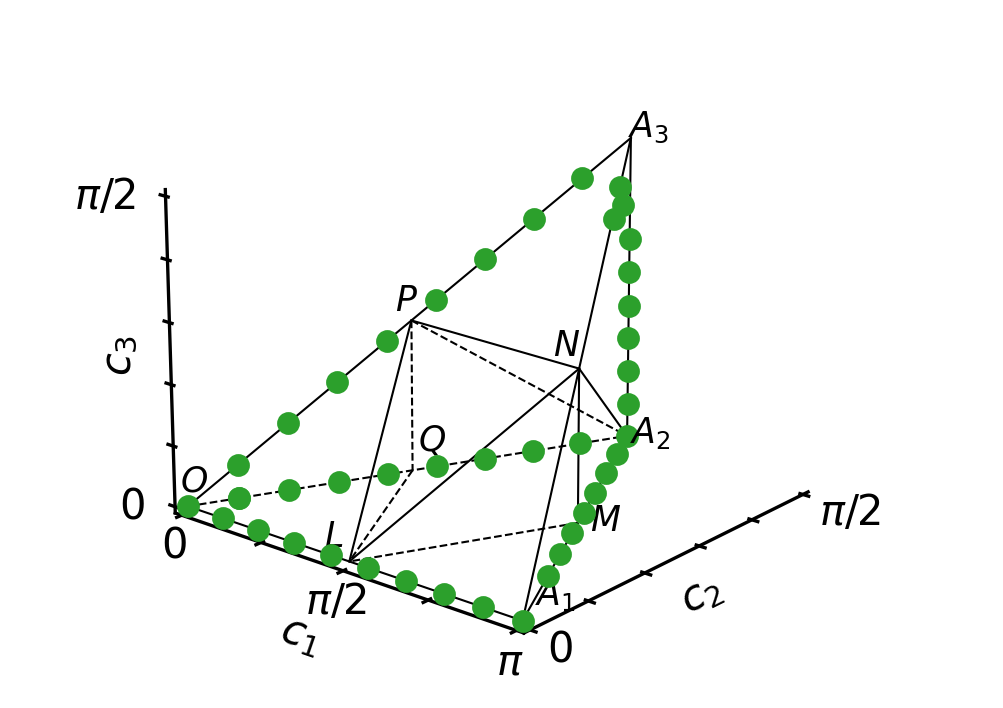

In [12]:
weyl_region_plot(riswap_param=1/3, template_range=[4]).plot()

INFO:root:(1/60) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/60) Found saved coordinate: (0.1111111111111111, 0.0, 0.0)
INFO:root:(3/60) Found saved coordinate: (0.2222222222222222, 0.0, 0.0)
INFO:root:(4/60) Found saved coordinate: (0.3333333333333333, 0.0, 0.0)
INFO:root:(5/60) Found saved coordinate: (0.4444444444444444, 0.0, 0.0)
INFO:root:(6/60) Found saved coordinate: (0.5555555555555556, 0.0, 0.0)
INFO:root:(7/60) Found saved coordinate: (0.6666666666666666, 0.0, 0.0)
INFO:root:(8/60) Found saved coordinate: (0.7777777777777777, 0.0, 0.0)
INFO:root:(9/60) Found saved coordinate: (0.8888888888888888, 0.0, 0.0)
INFO:root:(10/60) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(11/60) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(12/60) Found saved coordinate: (0.05555555555555555, 0.05555555555555555, 0.0)
INFO:root:(13/60) Found saved coordinate: (0.1111111111111111, 0.1111111111111111, 0.0)
INFO:root:(14/60) Found saved coordinate: (0.16666666666666666, 0.1666666

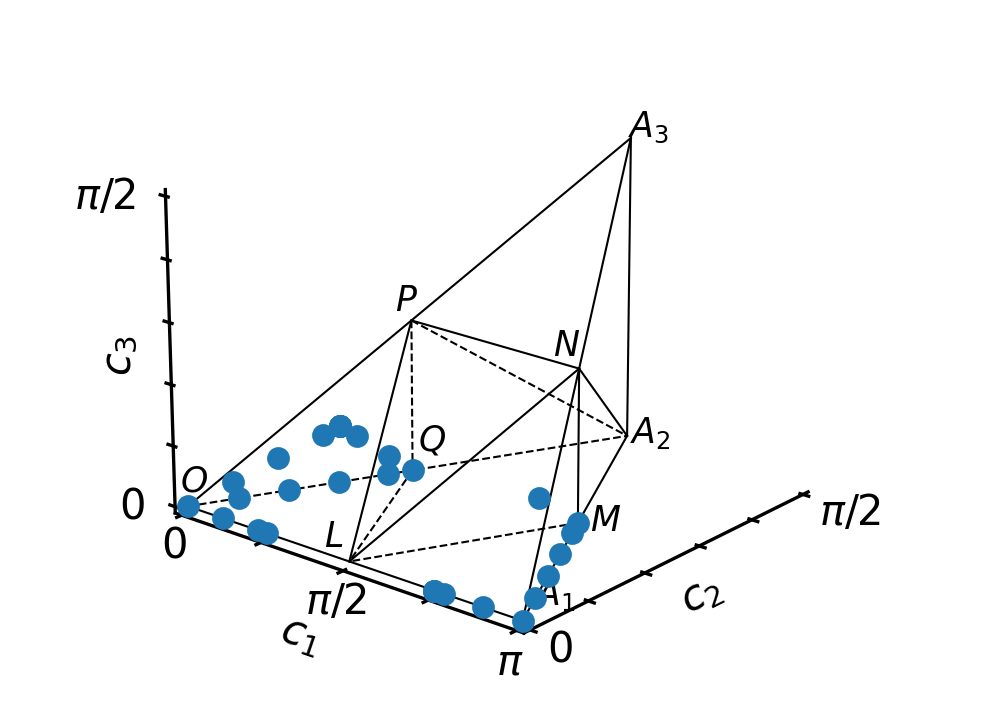

In [13]:
weyl_region_plot(riswap_param=1/4, template_range=[2]).plot()

INFO:root:(1/60) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/60) Found saved coordinate: (0.1111111111111111, 0.0, 0.0)
INFO:root:(3/60) Found saved coordinate: (0.2222222222222222, 0.0, 0.0)
INFO:root:(4/60) Found saved coordinate: (0.3333333333333333, 0.0, 0.0)
INFO:root:(5/60) Found saved coordinate: (0.4444444444444444, 0.0, 0.0)
INFO:root:(6/60) Found saved coordinate: (0.5555555555555556, 0.0, 0.0)
INFO:root:(7/60) Found saved coordinate: (0.6666666666666666, 0.0, 0.0)
INFO:root:(8/60) Found saved coordinate: (0.7777777777777777, 0.0, 0.0)
INFO:root:(9/60) Found saved coordinate: (0.8888888888888888, 0.0, 0.0)
INFO:root:(10/60) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(11/60) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(12/60) Found saved coordinate: (0.05555555555555555, 0.05555555555555555, 0.0)
INFO:root:(13/60) Found saved coordinate: (0.1111111111111111, 0.1111111111111111, 0.0)
INFO:root:(14/60) Found saved coordinate: (0.16666666666666666, 0.1666666

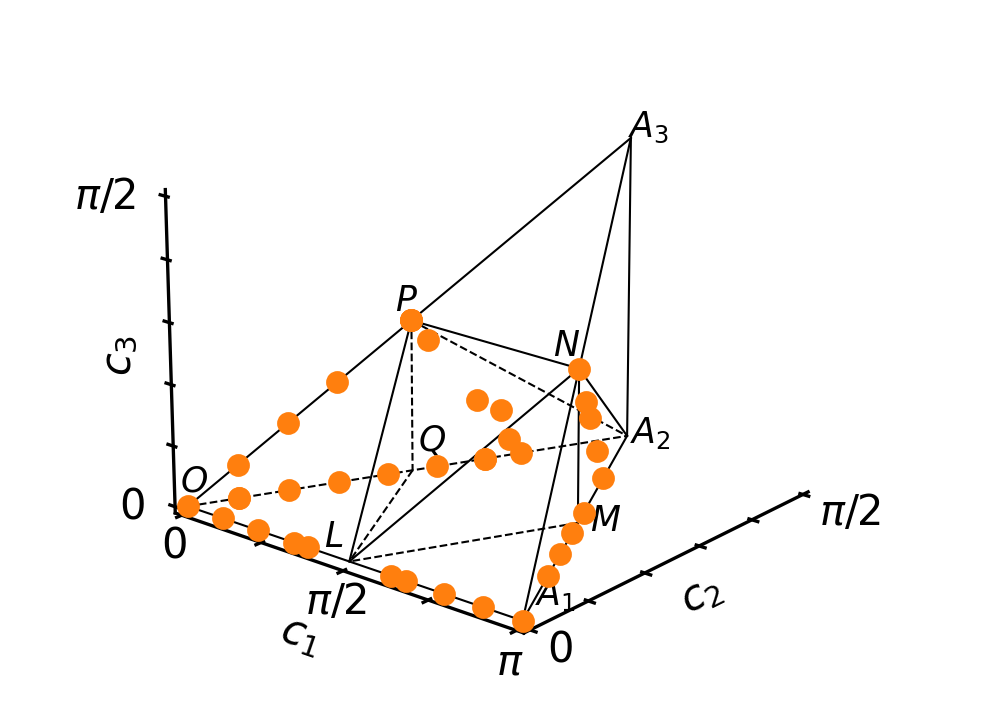

In [14]:
weyl_region_plot(riswap_param=1/4, template_range=[3]).plot()

INFO:root:(1/60) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/60) Found saved coordinate: (0.1111111111111111, 0.0, 0.0)
INFO:root:(3/60) Found saved coordinate: (0.2222222222222222, 0.0, 0.0)
INFO:root:(4/60) Found saved coordinate: (0.3333333333333333, 0.0, 0.0)
INFO:root:(5/60) Found saved coordinate: (0.4444444444444444, 0.0, 0.0)
INFO:root:(6/60) Found saved coordinate: (0.5555555555555556, 0.0, 0.0)
INFO:root:(7/60) Found saved coordinate: (0.6666666666666666, 0.0, 0.0)
INFO:root:(8/60) Found saved coordinate: (0.7777777777777777, 0.0, 0.0)
INFO:root:(9/60) Found saved coordinate: (0.8888888888888888, 0.0, 0.0)
INFO:root:(10/60) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(11/60) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(12/60) Found saved coordinate: (0.05555555555555555, 0.05555555555555555, 0.0)
INFO:root:(13/60) Found saved coordinate: (0.1111111111111111, 0.1111111111111111, 0.0)
INFO:root:(14/60) Found saved coordinate: (0.16666666666666666, 0.1666666

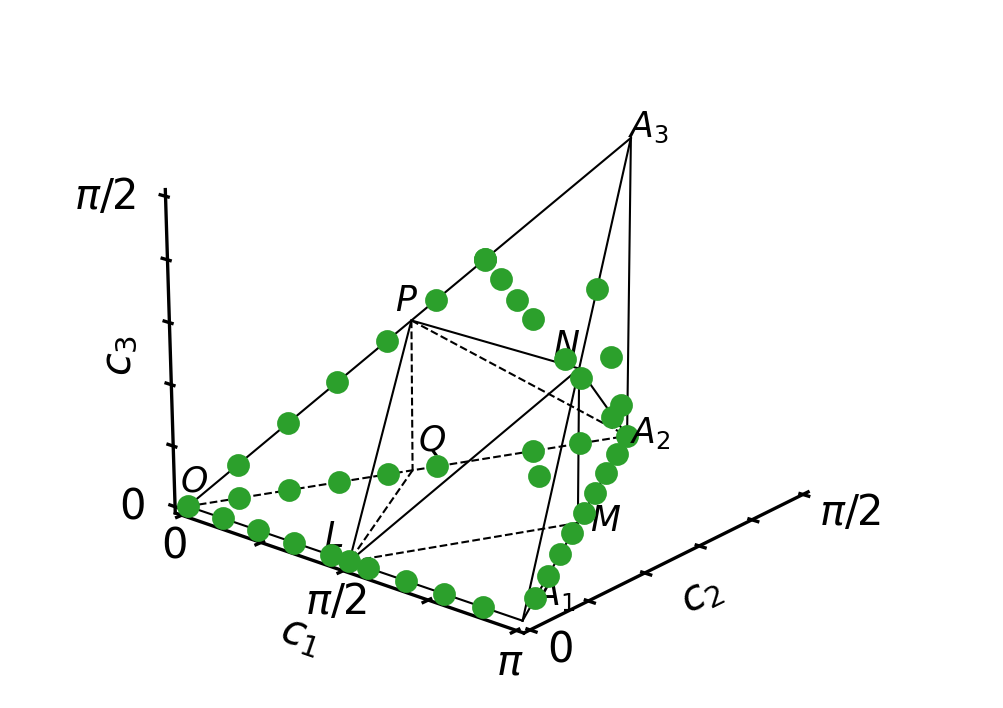

In [15]:
weyl_region_plot(riswap_param=1/4, template_range=[4]).plot()